In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from category_encoders import OrdinalEncoder

In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

**Understanding the data**
* Observing the data
* Data Visualization

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Using the copy of data from further

In [6]:
train1=train.copy()
test1=test.copy()

In [7]:
train1['Batch'] = train1['PassengerId'].str.split('_',expand = True)[0]
test1['Batch'] = test1['PassengerId'].str.split('_',expand = True)[0]

In [8]:
train1['Side'] = train1['Cabin'].str.split('/',expand=True)[2]
test1['Side'] = test1['Cabin'].str.split('/',expand=True)[2]

train1['Deck'] = train1['Cabin'].str.split('/',expand=True)[0]
test1['Deck'] = test1['Cabin'].str.split('/',expand=True)[0]

train1['Seat'] = train1['Cabin'].str.split('/',expand=True)[1]
test1['Seat'] = test1['Cabin'].str.split('/',expand=True)[1]

In [9]:
train1.replace('', np.nan, inplace=True)
test1.replace('', np.nan, inplace=True)

In [10]:
train2=train1.copy()
test2=test1.copy()

In [11]:
train2.drop(columns=['PassengerId','Cabin','Name','Batch'],axis=1,inplace=True)
test2.drop(columns=['PassengerId','Cabin','Name','Batch'],axis=1,inplace=True)

In [12]:
# Convert Seat column to numeric
train2['Seat'] = pd.to_numeric(train2['Seat'], errors='coerce')
test2['Seat'] = pd.to_numeric(test2['Seat'], errors='coerce')

In [13]:
# ordinal encoding for train data
ordinal_encoder = OrdinalEncoder(cols=['HomePlanet','CryoSleep','Destination','VIP','Side', 'Deck'], mapping=[{'col': 'Side', 'mapping': {'P': 0, 'S': 1}},
                                                                {'col': 'Deck', 'mapping': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}},
                                                                                                             {'col':'HomePlanet','mapping':{'Europa':0, 'Earth':1, 'Mars':2}},
                                                                                                             {'col':'CryoSleep','mapping':{False:0, True:1}},
                                                                                                             {'col':'Destination','mapping':{'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2}},
                                                                                                             {'col':'VIP','mapping':{False:0, True:1}}],handle_missing=-1)
train3 = ordinal_encoder.fit_transform(train2)


# ordinal encoding for test data
ordinal_encoder_test = OrdinalEncoder(cols=['HomePlanet','CryoSleep','Destination','VIP','Side', 'Deck'], mapping=[{'col': 'Side', 'mapping': {'P': 0, 'S': 1}},
                                                                {'col': 'Deck', 'mapping': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}},
                                                                                                             {'col':'HomePlanet','mapping':{'Europa':0, 'Earth':1, 'Mars':2}},
                                                                                                             {'col':'CryoSleep','mapping':{False:0, True:1}},
                                                                                                             {'col':'Destination','mapping':{'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2}},
                                                                                                             {'col':'VIP','mapping':{False:0, True:1}}],handle_missing=-1)
test3 = ordinal_encoder_test.fit_transform(test2)

In [14]:
test3

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Side,Deck,Seat
0,1.0,1.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,3.0
1,1.0,0.0,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,1.0,5.0,4.0
2,0.0,1.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
3,0.0,0.0,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,1.0,2.0,1.0
4,1.0,0.0,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,1.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,1.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1496.0
4273,1.0,0.0,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,-1.0,-1.0,NaN
4274,2.0,1.0,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,296.0
4275,0.0,0.0,-1.0,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,0.0,3.0,297.0


In [15]:
train3 = train3.replace(-1, np.nan)
test3 = test3.replace(-1, np.nan)

In [16]:
from sklearn.impute import KNNImputer

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
train3_imputed = pd.DataFrame(imputer.fit_transform(train3), columns=train3.columns)

print(train3_imputed)



# Initialize KNNImputer
imputer_test = KNNImputer(n_neighbors=5)

# Impute missing values
test3_imputed = pd.DataFrame(imputer_test.fit_transform(test3), columns=test3.columns)

# Output the imputed dataframe
print(test3_imputed)

      HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0            0.0        0.0          0.0  39.0  0.0          0.0        0.0   
1            1.0        0.0          0.0  24.0  0.0        109.0        9.0   
2            0.0        0.0          0.0  58.0  1.0         43.0     3576.0   
3            0.0        0.0          0.0  33.0  0.0          0.0     1283.0   
4            1.0        0.0          0.0  16.0  0.0        303.0       70.0   
...          ...        ...          ...   ...  ...          ...        ...   
8688         0.0        0.0          2.0  41.0  1.0          0.0     6819.0   
8689         1.0        1.0          1.0  18.0  0.0          0.0        0.0   
8690         1.0        0.0          0.0  26.0  0.0          0.0        0.0   
8691         0.0        0.0          2.0  32.0  0.0          0.0     1049.0   
8692         0.0        0.0          0.0  44.0  0.0        126.0     4688.0   

      ShoppingMall     Spa  VRDeck  Transported  Si

In [17]:
train4=train3_imputed.copy()
test4=test3_imputed.copy()

In [18]:
train4

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Side,Deck,Seat
0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,1.0,5.0,0.0
2,0.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,1.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,0.0,2.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0.0,0.0,98.0
8689,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1499.0
8690,1.0,0.0,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,1.0,6.0,1500.0
8691,0.0,0.0,2.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0.0,1.0,4.0,608.0


/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

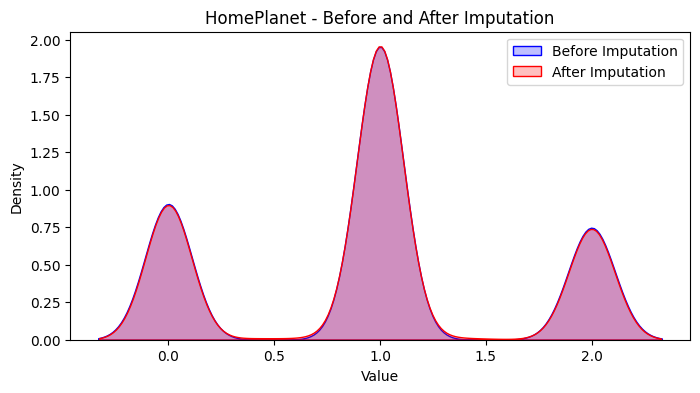

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

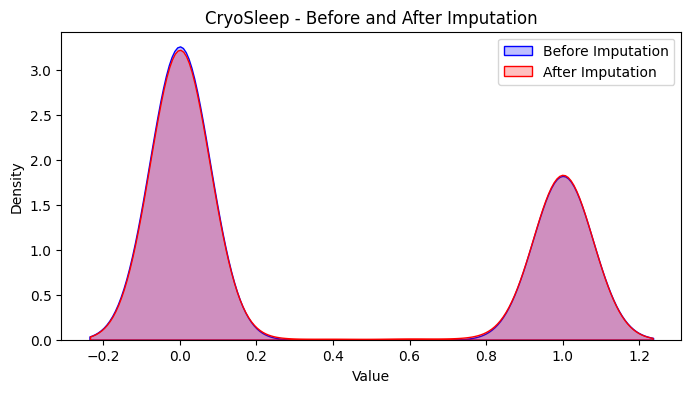

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

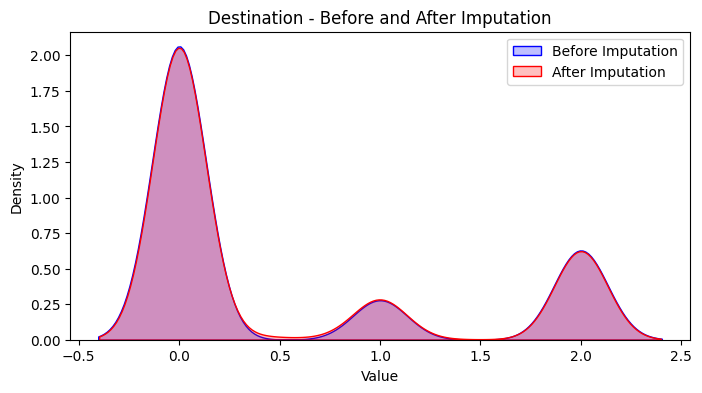

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

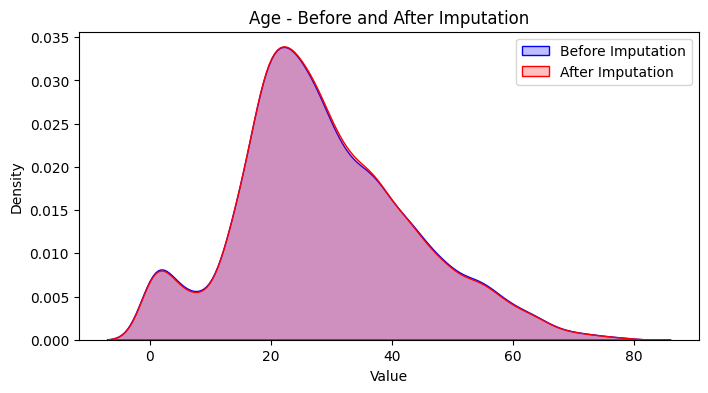

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

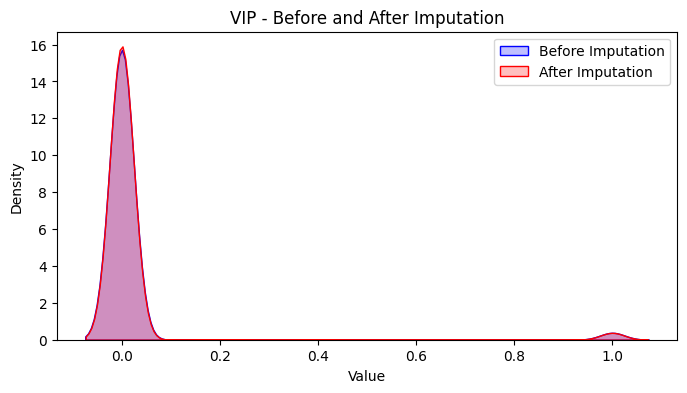

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

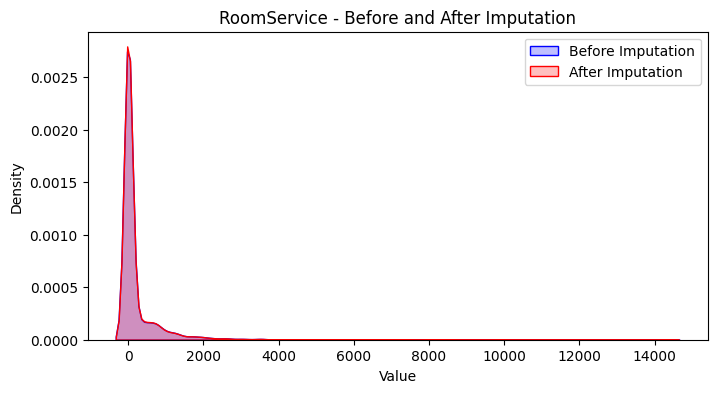

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

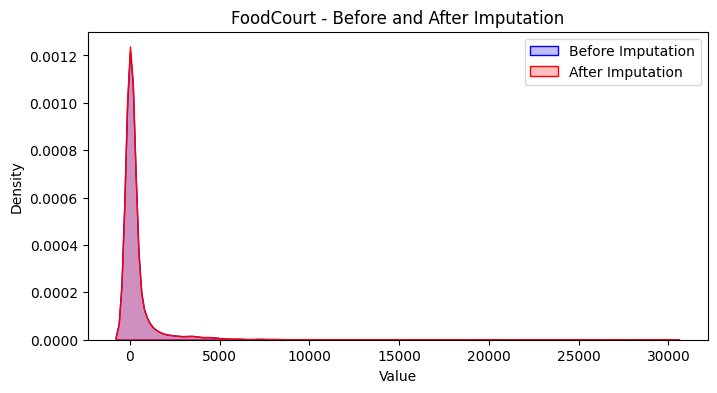

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

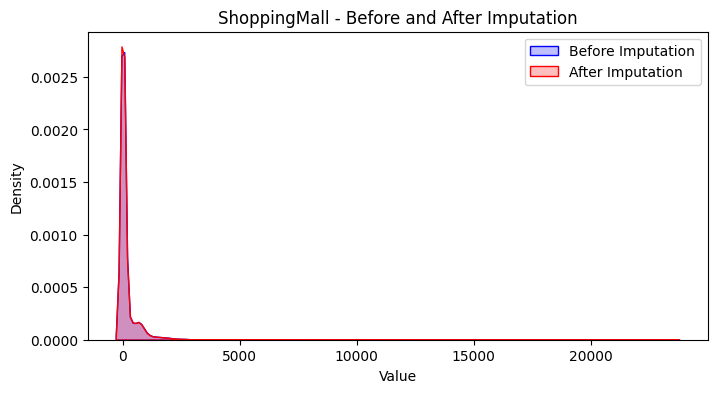

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

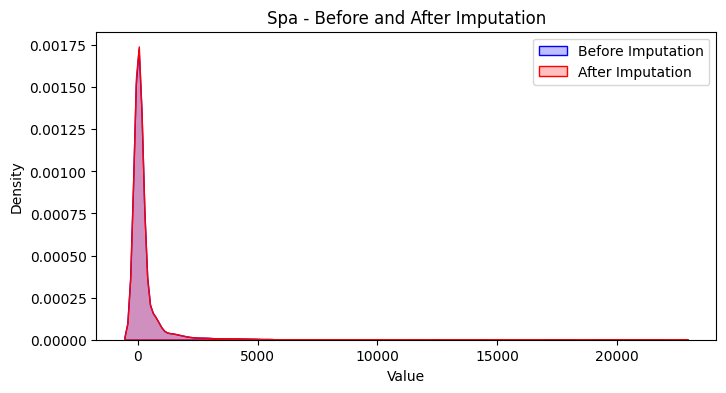

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

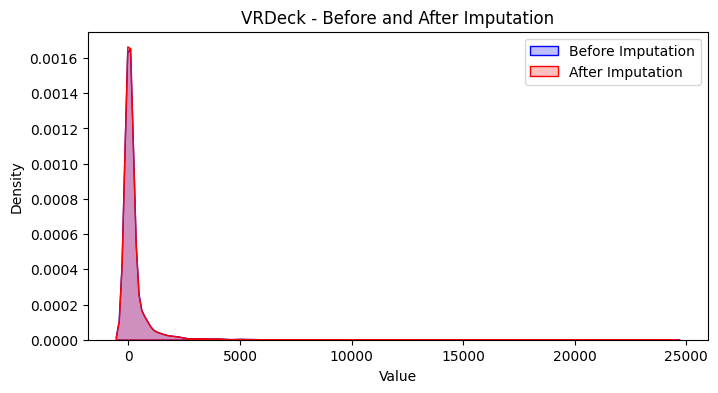

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

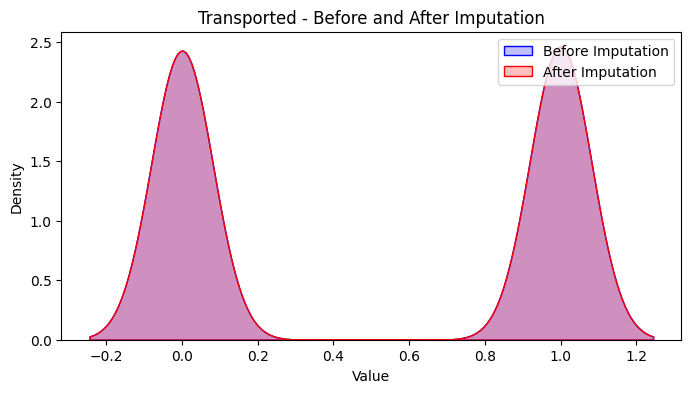

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

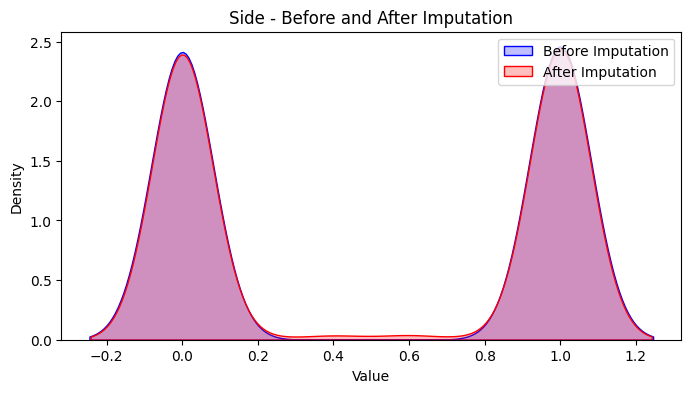

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

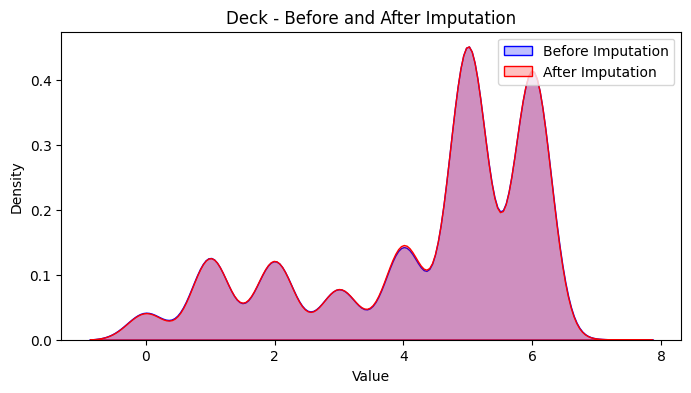

/tmp/ipykernel_18/467603044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/467603044.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

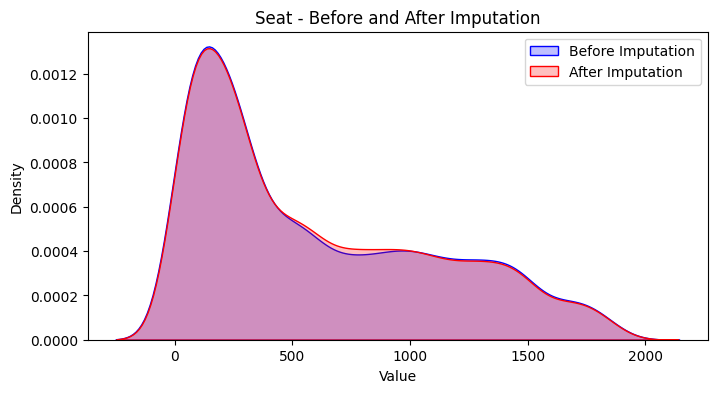

In [19]:
for column in train4.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(train3[column], color='b', shade=True, label='Before Imputation')
    sns.kdeplot(train4[column], color='r', shade=True, label='After Imputation')
    plt.title(f'{column} - Before and After Imputation')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

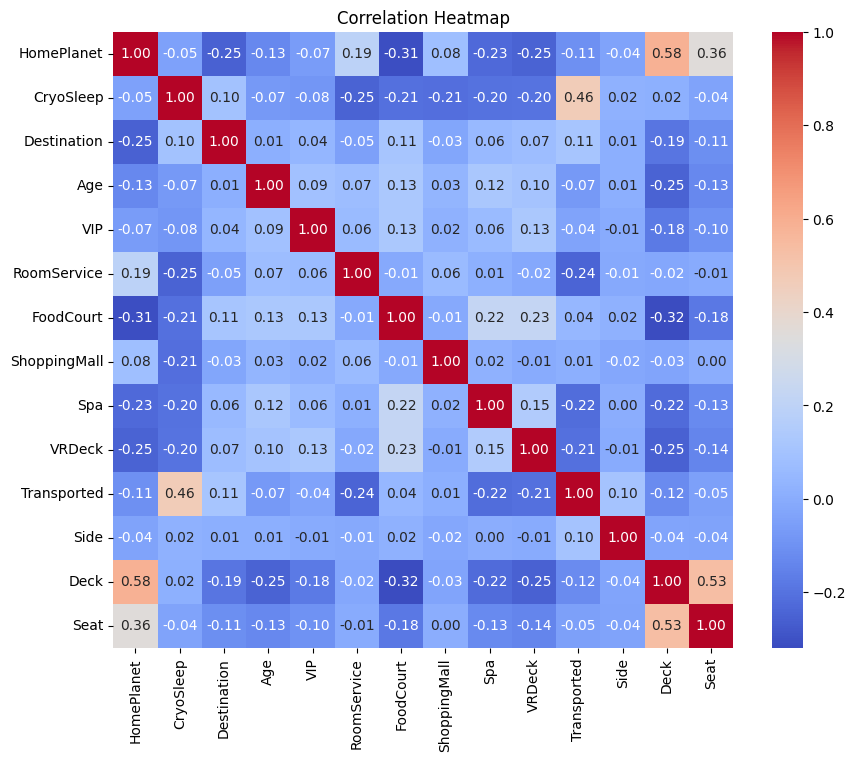

In [20]:
data_for_heatmap = train4.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(data_for_heatmap, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Heatmap')
plt.show()

In [21]:
train4=train3_imputed.copy()
test4=test3_imputed.copy()

Deep Learning Algorithm

In [22]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F 

In [23]:
X_train_val = train4.drop(['Transported'],axis=1)
y_train_val = train4['Transported']

In [24]:
X_train_val_T = torch.tensor(X_train_val.values).type(torch.FloatTensor)
y_train_val_T = torch.tensor(y_train_val.values).type(torch.FloatTensor)
X_test = torch.tensor(test4.values).type(torch.FloatTensor)

In [25]:
X_test.shape

torch.Size([4277, 13])

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_T,y_train_val_T,random_state=42,test_size=0.25)

In [27]:
y_train,y_val = y_train.reshape(-1,1),y_val.reshape(-1,1)

In [28]:
train_data = TensorDataset(X_train,y_train)
val_data = TensorDataset(X_val,y_val)

In [29]:
BATCH_SIZE = 128 #256 #32
train_dl = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle = True)
val_dl = DataLoader(val_data,batch_size=X_val.shape[0])

In [30]:
next(iter(train_dl))[0].shape

torch.Size([128, 13])

In [31]:
class ANNSapceshipModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.ann = nn.Sequential(
            nn.Linear(13,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        
    def forward(self,x):
        x = self.ann(x)
        return F.sigmoid(x)
    
model = ANNSapceshipModel()

# Defining loss
creiterion = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [32]:
next(iter(train_dl))[0].shape

torch.Size([128, 13])

In [33]:
nEpochs = 200
train_results = np.zeros((nEpochs,2))
val_results = np.zeros((nEpochs,2))

In [34]:
for i in range(nEpochs):
    # loop thru batch
    train_batch_loss = []
    train_batch_acc = []
    model.train()
    for x,y in train_dl:
        preds = model(x)
        #y = y.reshape(BATCH_SIZE,1)
        batch_loss = creiterion(preds,y)
        
        train_batch_loss.append(batch_loss.item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        pred_labels = (preds > 0.5).float()
        train_batch_acc.append(torch.mean((pred_labels == y).float()))
        
    train_results[i,0] = np.mean(train_batch_loss)
    train_results[i,1] = np.mean(train_batch_acc)
    ###########################################################
    val_batch_loss = []
    val_batch_acc = []
    
    model.eval()
    for x,y in val_dl:
        
        with torch.no_grad():
            val_preds = model(x)
            #y = y.reshape(next(iter(val_dl))[1].shape[0],1)
            batch_loss = creiterion(val_preds,y)
        
            val_batch_loss.append(batch_loss.item())
        
            pred_labels = (val_preds > 0.5).float()
            val_batch_acc.append(torch.mean((pred_labels == y).float()))

    val_results[i,0] = np.mean(val_batch_loss)
    val_results[i,1] = np.mean(val_batch_acc)

In [35]:
X_test.shape

torch.Size([4277, 13])

In [36]:
with torch.no_grad():
    test_preds = model(X_test)

test_preds_labels = test_preds > 0.5

In [37]:
test_pred = torch.squeeze(test_preds_labels).tolist()

In [38]:
prediction = {}
prediction['PassengerId'] = test1['PassengerId'].tolist()
prediction['Transported'] = test_pred

prediction = pd.DataFrame(prediction)
prediction.to_csv('prediction_Deep.csv',index=False)